Features for Trajectory Recommendation
=====

1. [Features](#sec1)
1. [Load Data](#sec2)
  1. [Compute POI Info](#sec2.1)
  1. [Construct Travelling Sequences](#sec2.2)
  1. [Compute Some Sequence Statistics](#sec2.3)
1. [Compute Transition Probabilities](#sec3)
  1. [Basic Definitions](#sec3.1)
  1. [Transition Probabilities between POI Categories](#sec3.2)
  1. [Transition Probabilities between POI Popularity Classes](#sec3.3)
  1. [Transition Probabilities between POI Pair Distance Classes](#sec3.5)
1. [Compute Trajectory Likelihood (For tuning the discretization strategy)](#sec4)
  1. [Log Likelihood of Actual Trajectories](#sec4.1)
  1. [Log Likelihood of Enumerated Trajectories](#sec4.2)
  1. [Compare the Log Likelihood of Actual and Enumerated Trajectories](#sec4.3)
  1. [Compute the F1-score of Enumerated Trajectories](#sec4.4)

<a id='sec1'></a>

# 1. Features

1. POI category (a transition matrix between different categories)
1. POI popularity (a transition matrix between different class of popularity)
1. POI pair distance (a transition matrix between different class of distance)

**Computation Steps:**
1. First compute the above features using a set of travelling sequences,
1. Then compute the log likelihood of (actual/enumerated) sequences using POI category/popularity transition matrix and POI pair distance transition matrix and make comparison.

<a id='sec2'></a>

# 2. Load Data

In [1483]:
%matplotlib inline

import os
import re
import math
import random
import pickle
import pandas as pd
import numpy as np
import scipy.stats
from numba import jit
from datetime import datetime
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [1484]:
nfeatures = 8 # number of features
EPS = 1e-12 # smooth, deal with 0 probability
random.seed(123456789) # control random choice when splitting training/testing set

In [1485]:
data_dir = 'data/data-ijcai15'
#fvisit = os.path.join(data_dir, 'userVisits-Osak.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Osak.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Glas.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Glas.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Edin.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Edin.csv')
fvisit = os.path.join(data_dir, 'userVisits-Toro.csv')
fcoord = os.path.join(data_dir, 'photoCoords-Toro.csv')

In [1486]:
suffix = fvisit.split('-')[-1].split('.')[0]

In [1487]:
visits = pd.read_csv(fvisit, sep=';')
coords = pd.read_csv(fcoord, sep=';')
# merge data frames according to column 'photoID'
assert(visits.shape[0] == coords.shape[0])
traj = pd.merge(visits, coords, on='photoID')
traj.head()

,photoID,userID,dateTaken,poiID,poiTheme,poiFreq,seqID,photoLon,photoLat
0,7941504100,10007579@N00,1346844688,30,Structure,1538,1,-79.380844,43.645641
1,4886005532,10012675@N05,1142731848,6,Cultural,986,2,-79.391525,43.654335
2,4886006468,10012675@N05,1142732248,6,Cultural,986,2,-79.391525,43.654335
3,4885404441,10012675@N05,1142732373,6,Cultural,986,2,-79.391525,43.654335
4,4886008334,10012675@N05,1142732445,6,Cultural,986,2,-79.391525,43.654335


In [1488]:
num_photo = traj['photoID'].unique().shape[0]
num_user = traj['userID'].unique().shape[0]
num_poi = traj['poiID'].unique().shape[0]
num_seq = traj['seqID'].unique().shape[0]
pd.DataFrame({'#photo': num_photo, '#user': num_user, '#poi': num_poi, '#seq': num_seq, \
              '#photo/user': num_photo/num_user, '#seq/user': num_seq/num_user}, index=[str(suffix)])

,#photo,#photo/user,#poi,#seq,#seq/user,#user
Toro,39419,28.257348,29,6057,4.341935,1395


In [1489]:
#plt.figure(figsize=[15, 5])
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.scatter(traj['photoLon'], traj['photoLat'], marker='+')

<a id='sec2.1'></a>

## 2.1 Compute POI Info

Compute POI (Longitude, Latitude) as the average coordinates of the assigned photos.

In [1490]:
poi_coords = traj[['poiID', 'photoLon', 'photoLat']].groupby('poiID').mean()
poi_coords.reset_index(inplace=True)
poi_coords.rename(columns={'photoLon':'poiLon', 'photoLat':'poiLat'}, inplace=True)

Extract POI category and visiting frequency.

In [1491]:
poi_catfreq = traj[['poiID', 'poiTheme', 'poiFreq']].groupby('poiID').first()
poi_catfreq.reset_index(inplace=True)

In [1492]:
poi_all = pd.merge(poi_catfreq, poi_coords, on='poiID')
poi_all.set_index('poiID', inplace=True)
#poi_all.to_csv(fpoi, index=True)

<a id='sec2.2'></a>

## 2.2 Construct Travelling Sequences

In [1493]:
seq_all = traj[['userID', 'seqID', 'poiID', 'dateTaken']].copy().groupby(['userID', 'seqID', 'poiID'])\
          .agg([np.min, np.max, np.size])
seq_all.columns = seq_all.columns.droplevel()
seq_all.reset_index(inplace=True)
seq_all.rename(columns={'amin':'arrivalTime', 'amax':'departureTime', 'size':'#photo'}, inplace=True)
seq_all['poiDuration(sec)'] = seq_all['departureTime'] - seq_all['arrivalTime']
#seq_all.head()

In [1494]:
seq_user = seq_all[['userID', 'seqID', 'poiID']].copy().groupby(['userID', 'seqID']).agg(np.size)
seq_user.reset_index(inplace=True)
seq_user.rename(columns={'size':'seqLen'}, inplace=True)
seq_user.set_index('seqID', inplace=True)
#seq_user.head()

<a id='sec2.3'></a>

## 2.3 Compute Some Sequence Statistics

In [1495]:
seq_len = seq_all[['seqID', 'poiID']].copy().groupby('seqID').agg(np.size)
seq_len.reset_index(inplace=True)
seq_len.rename(columns={'poiID':'seqLen'}, inplace=True)
#seq_len.head()

In [1496]:
seq_stats = seq_all[['seqID', '#photo', 'poiDuration(sec)']].copy().groupby('seqID').agg(np.sum)
seq_stats.reset_index(inplace=True)
#seq_stats.rename(columns={'poiDuration(sec)':'totalPoiDuration(sec)'}, inplace=True)
seq_stats = pd.merge(seq_len, seq_stats, on='seqID')
seq_stats['poiDuration(sec)'] /= 60
seq_stats.rename(columns={'poiDuration(sec)':'totalPoiDuration(min)'}, inplace=True)
seq_stats.set_index('seqID', inplace=True)
#seq_stats.head()

In [1497]:
#ax = seq_stats['seqLen'].hist(bins=50)
#ax.set_xlabel('sequence length')
#ax.set_ylim([0.1, 1e4])
#ax.set_yscale('log')

In [1498]:
#ax = seq_stats['#photo'].hist(bins=50)
#ax.set_xlabel('#photo for sequence')
#ax.set_ylim([0.1, 1e4])
#ax.set_yscale('log')

In [1499]:
#ax = seq_stats['totalPoiDuration(min)'].hist(bins=100)
#ax.set_xlabel('totalPoiDuration(min)')
#ax.set_ylim([0.1, 1e4])
#ax.set_yscale('log')
#ax.set_xscale('log')

Sequences with length {3, 4, 5}

In [1500]:
#seq_stats = seq_stats[seq_stats['seqLen'].isin({3, 4, 5})]
#ax = seq_stats['totalPoiDuration(min)'].hist(bins=50)
#ax.set_xlabel('totalPoiDuration(min)')
#ax.set_ylim([0.1, 1e4])
#ax.set_yscale('log')

In [1501]:
def extract_seq(seqid, seq_all):
    seqi = seq_all[seq_all['seqID'] == seqid].copy()
    seqi.sort(columns=['arrivalTime'], ascending=True, inplace=True)
    return seqi['poiID'].tolist()

<a id='sec3'></a>

# 3. Compute Transition Probabilities

<a id='sec3.1'></a>

## 3.1 Basic Definitions

- $\text{Pr}(\text{POI}_i \to \text{POI}_j)$: 
   the transition probability from $\text{POI}_i$ to $\text{POI }_j$
- $\text{Pr}(\text{Cat}_i \to \text{Cat}_j)$:
   the transition probability from a POI of category $\text{Cat}_i$ to a POI of category $\text{Cat}_j$
- $\text{Pr}(\text{Pop}_i \to \text{Pop}_j)$:
   the transition probability from a POI of Popularity class $\text{Pop}_i$ to a POI of Popularity class $\text{Pop}_j$
- $\text{Pr}(\text{Dist}_i \to \text{Dist}_j)$:
   the transition probability from a POI-POI pair with distance (between the two) class $\text{Dist}_i$ to a POI-POI pair with distance (between the two) class $\text{Dist}_j$

By design, $\text{Pr}(\text{POI}_i \to \text{POI}_j)$ should be bigger 
if any of $\text{Pr}(\text{Cat}_i \to \text{Cat}_j)$, $\text{Pr}(\text{Pop}_i \to \text{Pop}_j)$ and
$\text{Pr}(\text{Dist}_i \to \text{Dist}_j)$ becomes bigger (if other factors stay the same).

So how to combine these probabilities?  
Both addition and multiplication seems to be able to serve this purpose, what is the difference?

### The Addition Case

For the addtion case, 

\begin{equation}
\text{Pr}(\text{POI}_i \to \text{POI}_j) = \frac{
\text{Pr}(\text{Cat}_{\text{POI}_i} \to \text{Cat}_{\text{POI}_j}) + 
\text{Pr}(\text{Pop}_{\text{POI}_i} \to \text{Pop}_{\text{POI}_j}) + 
\text{Pr}(\text{Dist}_{\text{POI}_{i-1} \to \text{POI}_i} \to \text{Dist}_{\text{POI}_{i} \to \text{POI}_j})
}
{Z_i}
\end{equation}

where $\text{POI}_{i-1}$ is the direct predecessor of $\text{POI}_i$ in a trajectory and $Z_i$ is a normalizing constant.

### The Multiplication Case

For the multiplication case, 

\begin{equation}
\text{Pr}(\text{POI}_i \to \text{POI}_j) = \frac{
\text{Pr}(\text{Cat}_{\text{POI}_i} \to \text{Cat}_{\text{POI}_j}) \times
\text{Pr}(\text{Pop}_{\text{POI}_i} \to \text{Pop}_{\text{POI}_j}) \times
\text{Pr}(\text{Dist}_{\text{POI}_{i-1} \to \text{POI}_i} \to \text{Dist}_{\text{POI}_{i} \to \text{POI}_j})
}
{Z_i}
\end{equation}

similarly, $\text{POI}_{i-1}$ is the direct predecessor of $\text{POI}_i$ in a trajectory and $Z_i$ is again a normalizing constant.

### The Difference between Addition and Multiplication

It is important to note the fact that, by design, $\text{Pr}(\text{POI}_i \to \text{POI}_j)$ should be very small
if any of $\text{Pr}(\text{Cat}_i \to \text{Cat}_j)$, $\text{Pr}(\text{Pop}_i \to \text{Pop}_j)$ and
$\text{Pr}(\text{Dist}_i \to \text{Dist}_j)$ is very small, in the extreme case, if any of the three probabilities is $0$, then $\text{Pr}(\text{POI}_i \to \text{POI}_j)$ should be $0$
because the event "*Transition from POI$_i$ to POI$_j$*" is impossible.

From the equation of the addition case, it is clear that the addition rule **contradicts** the above fact while the multiplication rule is **consistent** with it.

Intuitively, the addition rule could make an unlikely event become much more likely, specifically, 
make an impossible event become possible.

<a id='sec3.2'></a>

## 3.2 Transition Probabilities between POI Categories

We model transition probabilities between POI categories, i.e.
$\text{Pr}(\text{Cat}_{\text{POI}_i} \to \text{Cat}_{\text{POI}_j})$.

We count the number of transition first, then normalise each row while taking care of zero by adding each cell a small number (i.e. $0.1$ times the minimum value of that row) if there exists a zero cell.

In [1502]:
def calc_poi_cat_transmat(seqid_set, poi_all, seq_all):
    poi_cats = poi_all['poiTheme'].unique().tolist()
    poi_cats.sort()
    poi_cat_transmat = pd.DataFrame(data=np.zeros((len(poi_cats), len(poi_cats)), dtype=np.float), \
                                    index=poi_cats, columns=poi_cats)
    for seqid in seqid_set:
        seq = extract_seq(seqid, seq_all)
        for j in range(len(seq)-1):
            poi1 = seq[j]
            poi2 = seq[j+1]
            cat1 = poi_all.loc[poi1, 'poiTheme']
            cat2 = poi_all.loc[poi2, 'poiTheme']
            poi_cat_transmat.loc[cat1, cat2] += 1
    return poi_cat_transmat

In [1503]:
def normalise_transmat(transmat):
    assert(isinstance(transmat, pd.DataFrame))
    for row in range(transmat.index.shape[0]):
        nonzeroidx = np.nonzero(transmat.iloc[row])[0].tolist()
        if len(nonzeroidx) < transmat.columns.shape[0]:
            minv = np.min(transmat.iloc[row, nonzeroidx])
            EPS = 0.1 * minv  # row-specific smooth factor
            #zeroidx = list(set(range(len(transmat.columns))) - set(nonzeroidx))
            #transmat.iloc[row, zeroidx] = EPS
            transmat.iloc[row] += EPS
        rowsum = np.sum(transmat.iloc[row])
        assert(rowsum > 0)
        transmat.iloc[row] /= rowsum
    return transmat        

In [1504]:
poi_cat_transmat = calc_poi_cat_transmat(seq_all['seqID'].unique(), poi_all, seq_all)
poi_cat_transmat

,Amusement,Beach,Cultural,Shopping,Sport,Structure
Amusement,14,20,51,17,35,16
Beach,18,43,61,92,19,106
Cultural,46,70,40,72,22,94
Shopping,16,101,58,16,19,71
Sport,42,23,21,13,8,21
Structure,26,91,81,59,24,24


In [1505]:
poi_cat_transmat = normalise_transmat(poi_cat_transmat)
poi_cat_transmat

,Amusement,Beach,Cultural,Shopping,Sport,Structure
Amusement,0.091503,0.130719,0.333333,0.111111,0.228758,0.104575
Beach,0.053097,0.126844,0.179941,0.271386,0.056047,0.312684
Cultural,0.133721,0.203488,0.116279,0.209302,0.063953,0.273256
Shopping,0.056940,0.359431,0.206406,0.056940,0.067616,0.252669
Sport,0.328125,0.179688,0.164062,0.101562,0.062500,0.164062
Structure,0.085246,0.298361,0.265574,0.193443,0.078689,0.078689


<a id='sec3.3'></a>

## 3.3 Transition Probabilities between POI Popularity Classes

We model transition probabilities between POI popularities, i.e.
$\text{Pr}(\text{Pop}_{\text{POI}_i} \to \text{Pop}_{\text{POI}_j})$
after discretizing POI popularities.

### 3.3.1 Discretize POI Popularity

What the general criteria of data discretization? [Discretization of continuous features](https://en.wikipedia.org/wiki/Discretization_of_continuous_features) from Wikipedia. 

~~**TODO**: Improve the discritization using Fayyad's minimum description length principle (MDLP)  described by [this paper](http://ijcai.org/Past%20Proceedings/IJCAI-93-VOL2/PDF/022.pdf)~~.

**NOTE**: MDLP is a supervised discretization method which requires some sort of class labels that are not available here. We need an unsupervised discretization method, well-known ones including equal width, equal frequency, clustering based, etc.

Try different discretization strategies and choose the best one using the following metrics:

`actSeqRank(Top%)` = $100 \times \frac{\text{rank of actual sequence}~S_a}{\text{number of enumerated sequence w.r.p}~S_a}$

`rankTop5(%)` = $100 \times \frac{\sum{\delta(\text{rank of actual sequence} \le 5)}}
{\text{number of actual sequence}}$, where $\delta(\text{True}) = 1$ and $\delta(\text{False}) = 0$  
i.e. the percentage of actual sequence $S_a$ ranked top 5 among all enumerated sequences with respect to $S_a$.

In [1506]:
poi_all['poiFreq'].get_values()

array([3506,  609,  688, 3056,  986, 2064, 1736,  278,  346, 4142,  481,
        964,  141,  113, 3553,  808,   26,  111,   89, 3594, 3619, 1874,
       1028, 1701,  104,  631,  936,  744, 1538])

In [1507]:
poi_all['poiFreq'].describe()

count      29.000000
mean     1360.896552
std      1289.191534
min        26.000000
25%       346.000000
50%       936.000000
75%      1874.000000
max      4142.000000
Name: poiFreq, dtype: float64

In [1508]:
poi_all['poiFreq'].quantile([.25, .5, .75]).tolist()

[346.0, 936.0, 1874.0]

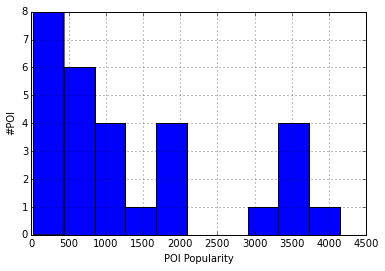

In [1509]:
ax = poi_all['poiFreq'].hist(bins=10)
ax.set_xlabel('POI Popularity')
ax.set_ylabel('#POI')

In [1510]:
#plt.plot(np.ones(poi_all.index.shape[0]), np.sqrt(poi_all['poiFreq']), marker='+')

### Quantile based bins (equal frequency)

In [1511]:
#nbins = 3
#quantiles = np.round(np.linspace(0, 1, nbins+1), 2)[1:-1]
#quantiles

In [1512]:
#bins_qt = [0]
#bins_qt.extend(poi_all['poiFreq'].quantile(quantiles))
#bins_qt.append(poi_all['poiFreq'].max() + 1)
#bins_qt

<table>
<tr><td><b>descretization strategy</b></td><td><b>actSeqRank(Top%) (smaller is better) Toronto</b></td><td><b>rankTop5(%) (larger is better) Toronto</b></td></tr>
<tr><td>quantile [0.33, 0.67]</td><td>mean: 16.049, std: 19.873</td><td>131/266 = 49.25%</td>
<tr><td>quantile [0.25, 0.5, 0.75]</td><td>mean: 16.478, std: 21.002</td><td>132/266 = 49.62%</td>
<tr><td>quantile [0.2, 0.4, 0.6, 0.8]</td><td>mean: 16.811, std: 22.159</td><td>127/266 = 47.74%</td>
<tr><td>quantile [0.17, 0.33, 0.5, 0.67, 0.83]</td><td>mean: 15.049, std: 18.722</td><td>128/266 = 48.12%</td>
<tr><td>quantile [0.14, 0.29, 0.43, 0.57, 0.71, 0.86]</td><td>mean: 15.831, std: 20.140</td><td>130/266 = 48.87%</td>
<tr><td>quantile [0.12, 0.25, 0.38, 0.5, 0.62, 0.75, 0.88]</td><td>mean: 15.567, std: 19.811</td><td>135/266 = 50.75%</td>
<tr><td>quantile [0.11, 0.22, 0.33, 0.44, 0.56, 0.67, 0.78, 0.89]</td><td>mean: 14.556, std: 17.937</td><td>138/266 = 51.88%</td>
<tr><td>quantile [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]</td><td>mean: 14.398, std: 17.694</td><td>135/266 = 50.75%</td>
<tr><td>quantile [0.09, 0.18, 0.27, 0.36, 0.45, 0.55, 0.64, 0.73, 0.82, 0.91]</td><td>mean: 14.874, std: 18.915</td><td>138/266 = 51.88%</td>
<tr><td>quantile [0.08, 0.17, 0.25, 0.33, 0.42, 0.5, 0.58, 0.67, 0.75, 0.83, 0.92]</td><td>mean: 13.491, std: 16.760</td><td>145/266 = 54.51%</td>
<tr><td>quantile [0.08, 0.15, 0.23, 0.31, 0.38, 0.46, 0.54, 0.62, 0.69, 0.77, 0.85, 0.92]</td><td>mean: 13.528, std: 16.964</td><td>144/266 = 54.14%</td>
<tr><td>quantile [0.07, 0.14, 0.21, 0.29, 0.36, 0.43, 0.5, 0.57, 0.64, 0.71, 0.79, 0.86, 0.93]</td><td>mean: 13.279, std: 15.960</td><td>142/266 = 53.38%</td>
<tr><td>quantile [0.07, 0.13, 0.2, 0.27, 0.33, 0.4, 0.47, 0.53, 0.6, 0.67, 0.73, 0.8, 0.87, 0.93]</td><td>mean: 12.784, std: 15.796</td><td>151/266 = 56.77%</td>
<tr><td>equalWidth, nbins=2</td><td>mean: 24.761, std: 29.356</td><td>115/266 = 43.23%</td>
<tr><td>equalWidth, nbins=3</td><td>mean: 21.841, std: 28.366</td><td>127/266 = 47.74%</td>
<tr><td>equalWidth, nbins=4</td><td>mean: 23.636, std: 29.252</td><td>120/266 = 45.11%</td>
<tr><td>equalWidth, nbins=5</td><td>mean: 20.154, std: 26.713</td><td>125/266 = 46.99%</td>
<tr><td>equalWidth, nbins=6</td><td>mean: 19.129, std: 25.530</td><td>125/266 = 46.99%</td>
<tr><td>equalWidth, nbins=7</td><td>mean: 16.922, std: 20.619</td><td>126/266 = 47.37%</td>
<tr><td>equalWidth, nbins=8</td><td>mean: 18.240, std: 22.739</td><td>121/266 = 45.49%</td>
<tr><td>equalWidth, nbins=9</td><td>mean: 17.507, std: 22.659</td><td>129/266 = 48.50%</td>
<tr><td>equalWidth, nbins=10</td><td>mean: 18.196, std: 23.321</td><td>125/266 = 46.99%</td>
<tr><td>equalWidth, nbins=11</td><td>mean: 17.711, std: 23.398</td><td>131/266 = 49.25%</td>
<tr><td>equalWidth, nbins=12</td><td>mean: 17.389, std: 22.718</td><td>132/266 = 49.62%</td>
<tr><td>equalWidth, nbins=13</td><td>mean: 15.820, std: 20.856</td><td>141/266 = 53.01%</td>
<tr><td>equalWidth, nbins=14</td><td>mean: 15.681, std: 19.559</td><td>136/266 = 51.13%</td>
<tr><td>equalWidth, nbins=15</td><td>mean: 15.712, std: 19.794</td><td>136/266 = 51.13%</td>
</table>

### Equal width bins

In [1513]:
nbins = 15
inter = round((poi_all['poiFreq'].max() + 1) / nbins)
bins_ew = [x*inter for x in range(nbins)]
bins_ew.append(poi_all['poiFreq'].max() + 1)
bins_ew

[0.0,
 276.0,
 552.0,
 828.0,
 1104.0,
 1380.0,
 1656.0,
 1932.0,
 2208.0,
 2484.0,
 2760.0,
 3036.0,
 3312.0,
 3588.0,
 3864.0,
 4143]

### Another Equal frequency bins

In [1514]:
#bins = np.linspace(0, 10000, 11)
#bins = np.logspace(0, 4, 5)
#bins = [1, 100, 500, 1000, 2000, 5000]
bins_ef = [0, 500, 1500, 10000]

The mean and standard deviation of actSeqRank(Top%) with respect to the above bins are `(mean: 16.4152260994, std: 17.410357672)`, `numRankTop5 = 114`

It seems that the type of POI popularity discretization has little effect on the results, let's use Quantile based bins.

In [1515]:
#bins_pop = bins_qt
bins_pop = bins_ew
#bins_pop = bins_ef

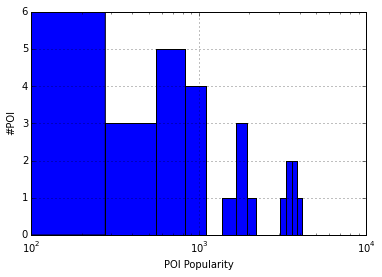

In [1516]:
ax = poi_all['poiFreq'].hist(bins=bins_pop)
ax.set_xlabel('POI Popularity')
ax.set_ylabel('#POI')
ax.set_xscale('log')

In [1517]:
poi_all['popClass'] = np.digitize(poi_all['poiFreq'].get_values(), bins_pop)
#poi_all

### 3.3.2 Compute Transition Probabilities

In [1518]:
def calc_poi_pop_transmat(seqid_set, poi_all, seq_all):
    pop_class = poi_all['popClass'].unique().tolist()
    pop_class.sort()
    poi_pop_transmat = pd.DataFrame(data=np.zeros((len(pop_class), len(pop_class)), dtype=np.float), \
                                    index=pop_class, columns=pop_class)
    for seqid in seqid_set:
        seq = extract_seq(seqid, seq_all)
        for j in range(len(seq)-1):
            poi1 = seq[j]
            poi2 = seq[j+1]
            pc1 = poi_all.loc[poi1, 'popClass']
            pc2 = poi_all.loc[poi2, 'popClass']
            poi_pop_transmat.loc[pc1, pc2] += 1
    return poi_pop_transmat

In [1519]:
poi_pop_transmat = calc_poi_pop_transmat(seq_all['seqID'].unique(), poi_all, seq_all)
poi_pop_transmat

,1,2,3,4,6,7,8,12,13,14,15
1,8,0,9,2,1,0,4,1,3,4,0
2,0,0,0,0,0,0,0,0,1,3,1
3,13,1,18,13,7,14,3,1,5,22,21
4,4,0,11,10,22,54,13,8,26,87,18
6,0,0,2,15,0,20,41,3,29,25,1
7,3,0,18,62,29,7,9,10,30,95,10
8,2,0,3,22,42,17,0,1,20,25,4
12,0,1,1,4,5,7,0,0,25,5,0
13,2,0,6,23,21,41,15,26,6,19,5
14,0,2,25,99,19,89,21,6,17,41,6


In [1520]:
poi_pop_transmat = normalise_transmat(poi_pop_transmat)
poi_pop_transmat

,1,2,3,4,6,7,8,12,13,14,15
1,0.244713,0.003021,0.274924,0.063444,0.033233,0.003021,0.123867,0.033233,0.093656,0.123867,0.003021
2,0.016393,0.016393,0.016393,0.016393,0.016393,0.016393,0.016393,0.016393,0.180328,0.508197,0.180328
3,0.110169,0.008475,0.152542,0.110169,0.059322,0.118644,0.025424,0.008475,0.042373,0.186441,0.177966
4,0.017094,0.001554,0.044289,0.040404,0.087024,0.211344,0.052059,0.032634,0.102564,0.339549,0.071484
6,0.000729,0.000729,0.015317,0.110139,0.000729,0.146608,0.299781,0.022611,0.212254,0.183078,0.008023
7,0.011944,0.001086,0.066232,0.225480,0.106044,0.026421,0.033659,0.037278,0.109663,0.344915,0.037278
8,0.015317,0.000729,0.022611,0.161196,0.307075,0.124726,0.000729,0.008023,0.146608,0.183078,0.029905
12,0.002037,0.022403,0.022403,0.083503,0.103870,0.144603,0.002037,0.002037,0.511202,0.103870,0.002037
13,0.013237,0.001203,0.037304,0.139591,0.127557,0.247894,0.091456,0.157641,0.037304,0.115523,0.031288
14,0.000611,0.006724,0.077017,0.303178,0.058680,0.272616,0.064792,0.018949,0.052567,0.125917,0.018949


<a id='sec3.5'></a>

## 3.5 Transition Probabilities between POI Pair Distance Classes

We model transition probabilities between different POI pair distances, i.e.
$\text{Pr}(\text{Dist}_{\text{POI}_{i-1} \to \text{POI}_i} \to \text{Dist}_{\text{POI}_{i} \to \text{POI}_j})$
after discretize POI pair distances.

Compute POI-pair distance if the pair is **observed** in dataset.

### TODO: Improve the distance calculation using Google maps [distance API](https://developers.google.com/maps/documentation/distance-matrix/intro) with different [travel modes](https://developers.google.com/maps/documentation/distance-matrix/intro#travel_modes) demonstrated [here](https://jakevdp.github.io/blog/2015/10/17/analyzing-pronto-cycleshare-data-with-python-and-pandas/).

### 3.5.1 Compute POI Pair Distance

In [1521]:
def calc_dist(longitude1, latitude1, longitude2, latitude2):
    """Calculate the distance (unit: km) between two places on earth"""
    # convert degrees to radians
    lon1 = math.radians(longitude1)
    lat1 = math.radians(latitude1)
    lon2 = math.radians(longitude2)
    lat2 = math.radians(latitude2)
    radius = 6371.009 # mean earth radius is 6371.009km, en.wikipedia.org/wiki/Earth_radius#Mean_radius
    # The haversine formula, en.wikipedia.org/wiki/Great-circle_distance
    dlon = math.fabs(lon1 - lon2)
    dlat = math.fabs(lat1 - lat2)
    return 2 * radius * math.asin( math.sqrt( \
               (math.sin(0.5*dlat))**2 + math.cos(lat1) * math.cos(lat2) * (math.sin(0.5*dlon))**2 ))

In [1522]:
def calc_obs_poipair_distmat(seqid_set, poi_all, seq_all):
    poi_distmat = pd.DataFrame(data=np.full((poi_all.shape[0], poi_all.shape[0]), np.nan, dtype=np.float), \
                               index=poi_all.index, columns=poi_all.index)
    for seqid in seqid_set:
        seq = extract_seq(seqid, seq_all)
        if len(seq) < 2: continue
        for j in range(len(seq)-1):
            poi1 = seq[j]
            poi2 = seq[j+1]
            if np.isnan(poi_distmat.loc[poi1, poi2]):
                dist = calc_dist(poi_all.loc[poi1, 'poiLon'], poi_all.loc[poi1, 'poiLat'], \
                                 poi_all.loc[poi2, 'poiLon'], poi_all.loc[poi2, 'poiLat'])
                poi_distmat.loc[poi1, poi2] = dist
                poi_distmat.loc[poi2, poi1] = dist
    return poi_distmat

In [1523]:
poi_distmat = calc_obs_poipair_distmat(seq_all['seqID'].unique(), poi_all, seq_all)
#poi_distmat

### 3.5.2 Discretize POI Pair Distance

In [1524]:
#distdata = pd.Series([x for x in np.unique(poi_distmat.get_values().flatten()) if not np.isnan(x)])
distdata = pd.Series([poi_distmat.iloc[x, y] \
                      for x in range(poi_distmat.index.shape[0]) \
                      for y in range(x+1, poi_distmat.index.shape[0]) \
                      if not np.isnan(poi_distmat.iloc[x, y])])

In [1525]:
distdata.describe()

count    179.000000
mean       2.069742
std        1.659092
min        0.147439
25%        0.975327
50%        1.710602
75%        2.655934
max        9.857157
dtype: float64

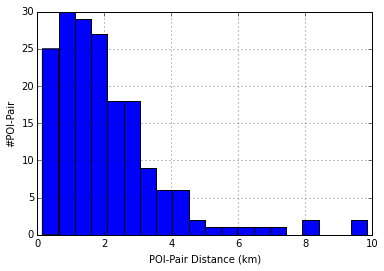

In [1526]:
ax = distdata.hist(bins=20)
ax.set_xlabel('POI-Pair Distance (km)')
ax.set_ylabel('#POI-Pair')

### Quantile based bins (equal frequency)

In [1527]:
#bins = [0, 0.976, 1.711, 2.656, 10]
bins_qt = [0]
bins_qt.extend(np.round(distdata.quantile([.25, .5, .75]).get_values(), 3))
bins_qt.append(10*round(distdata.max()))
bins_qt

[0, 0.97499999999999998, 1.7110000000000001, 2.6560000000000001, 100.0]

The mean and standard deviation of actSeqRank(Top%) with respect to the above bins are `(mean: 16.4152260994, std: 17.410357672), numRankTop5 = 114`

### Equal width bins

In [1528]:
nbins = 4 # 2 results the last bin be empty
inter = round((round(distdata.max()) + 1) / nbins)
bins_ew = [x*inter for x in range(nbins)]
bins_ew.append(10*round(distdata.max()))
bins_ew

[0.0, 3.0, 6.0, 9.0, 100.0]

`nbins=2` results the last bin be empty  
`nbins=3` results the last bin be empty  
`nbins=4` results the last two bins be empty  

### Another Equal frequency bins

In [1529]:
bins_ef = [0, 1.15, 2.25, 100]

The mean and standard deviation of `actSeqRank(Top%)` with respect to the above bins are `(mean: 16.4152260994, std: 17.410357672), numRankTop5 = 114`

It seems that the type of POI-pair distance discretization has little effect on the results, let's use Quantile based bins.

In [1530]:
#bins = np.linspace(0, 10, 7)
#bins = np.logspace(0, 2, 4)
#bins = [0, 1, 2, 3, 10]
#bins = [0, 2, 5, 100] # walk, ride, drive

In [1531]:
bins_dist = bins_qt
#bins_dist = bins_ew
#bins_dist = bins_ef

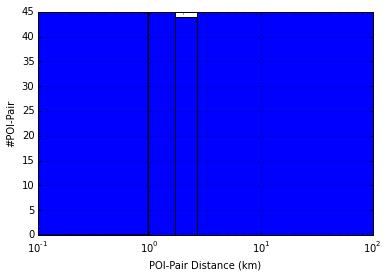

In [1532]:
ax = distdata.ix[np.nonzero(distdata)].hist(bins=bins_dist)
ax.set_xlabel('POI-Pair Distance (km)')
ax.set_ylabel('#POI-Pair')
ax.set_xscale('log')

In [1533]:
poi_distclass_mat = pd.DataFrame(data=np.full((poi_all.shape[0], poi_all.shape[0]), np.nan, dtype=np.float), \
                                 index=poi_all.index, columns=poi_all.index)

In [1534]:
for i in range(poi_all.index.shape[0]):
    poi1 = poi_all.index[i]
    for j in range(i+1, poi_all.index.shape[0]):
        poi2 = poi_all.index[j]
        if np.isnan(poi_distmat.loc[poi1, poi2]): continue
        dc = np.digitize([poi_distmat.loc[poi1, poi2]], bins_dist)[0]
        poi_distclass_mat.loc[poi1, poi2] = dc
        poi_distclass_mat.loc[poi2, poi1] = dc

In [1535]:
#poi_distclass_mat

### 3.5.3 Compute Transition Probabilities

In [1536]:
def calc_poipair_dist_transmat(seqid_set, poi_all, seq_all, poi_distclass_mat):
    dist_class = [int(poi_distclass_mat.iloc[x, y]) \
                  for x in range(poi_distclass_mat.index.shape[0]) \
                  for y in range(x+1, poi_distclass_mat.index.shape[0]) \
                  if not np.isnan(poi_distclass_mat.iloc[x, y])]
    dist_class = np.unique(np.array(dist_class))
    poipair_dist_transmat = pd.DataFrame(data=np.zeros((len(dist_class), len(dist_class)), dtype=np.float), \
                                         index=dist_class, columns=dist_class)
    for seqid in seqid_set:
        seq = extract_seq(seqid, seq_all)
        if len(seq) < 3: continue
        for j in range(1, len(seq)-1):
            poi1 = seq[j-1]
            poi2 = seq[j]
            poi3 = seq[j+1]
            dc1 = int(poi_distclass_mat.loc[poi1, poi2])
            dc2 = int(poi_distclass_mat.loc[poi2, poi3])
            assert(not np.isnan(dc1))
            assert(not np.isnan(dc2))
            poipair_dist_transmat.loc[dc1, dc2] += 1
    return poipair_dist_transmat

In [1537]:
poipair_dist_transmat = calc_poipair_dist_transmat(seq_all['seqID'].unique(), poi_all, seq_all, poi_distclass_mat)
poipair_dist_transmat

,1,2,3,4
1,317,74,23,7
2,59,16,10,6
3,19,7,5,4
4,12,3,3,8


In [1538]:
poipair_dist_transmat = normalise_transmat(poipair_dist_transmat)
poipair_dist_transmat

,1,2,3,4
1,0.752969,0.175772,0.054632,0.016627
2,0.648352,0.175824,0.109890,0.065934
3,0.542857,0.200000,0.142857,0.114286
4,0.461538,0.115385,0.115385,0.307692


<a id='sec4'></a>

# 4. Compute Trajectory Likelihood (For tuning the discretization strategy)

Log likelihood of trajectory $[\text{POI}_1, \text{POI}_2, \dots, \text{POI}_i, ..., \text{POI}_N]$ is defined as
\begin{align}
\text{logl} =& 
\sum_{i=1}^{N-1} \log(\text{Pr}(\text{Cat}_{\text{POI}_i} \to \text{Cat}_{\text{POI}_{i+1}})) + 
\sum_{i=1}^{N-1} \log(\text{Pr}(\text{Pop}_{\text{POI}_i} \to \text{Pop}_{\text{POI}_{i+1}})) + 
\sum_{i=2}^{N-1} \log(\text{Pr}(\text{Dist}_{\text{POI}_{i-1} \to \text{POI}_i} \to 
\text{Dist}_{\text{POI}_{i} \to \text{POI}_{i+1}})) \\
& + \log(\text{Pr}(\text{POI}_1)) 
\end{align}

where $\text{Pr}(\text{POI}_1)$ is the prior of $\text{POI}_1$ and we assume $\text{Pr}(\text{POI}_1)=1.0$, 10-based logarithm is used here.

In [1539]:
def calc_seq_loglikelihood(seq, poi_all, poi_cat_transmat, poi_pop_transmat, \
                           poi_distclass_mat, poipair_dist_transmat, bins_dist):
    assert(len(seq) > 1)
    cat1 = poi_all.loc[seq[0], 'poiTheme']
    cat2 = poi_all.loc[seq[1], 'poiTheme']
    pc1  = poi_all.loc[seq[0], 'popClass']
    pc2  = poi_all.loc[seq[1], 'popClass']
    logL = math.log10(poi_cat_transmat.loc[cat1, cat2]) + math.log10(poi_pop_transmat.loc[pc1, pc2])
    for j in range(1, len(seq)-1):
        poi1 = seq[j-1]
        poi2 = seq[j]
        poi3 = seq[j+1]
        cat2 = poi_all.loc[poi2, 'poiTheme']
        cat3 = poi_all.loc[poi3, 'poiTheme']
        pc2  = poi_all.loc[poi2, 'popClass']
        pc3  = poi_all.loc[poi3, 'popClass']
        dc12 = poi_distclass_mat.loc[poi1, poi2]
        dc23 = poi_distclass_mat.loc[poi2, poi3]
        if np.isnan(dc12):
            dist12 = calc_dist(poi_all.loc[poi1, 'poiLon'], poi_all.loc[poi1, 'poiLat'], \
                               poi_all.loc[poi2, 'poiLon'], poi_all.loc[poi2, 'poiLat'])
            #print(dist12)
            dc12 = np.digitize([dist12], bins_dist)[0]
        if np.isnan(dc23):
            dist23 = calc_dist(poi_all.loc[poi2, 'poiLon'], poi_all.loc[poi2, 'poiLat'], \
                               poi_all.loc[poi3, 'poiLon'], poi_all.loc[poi3, 'poiLat'])
            #print(dist23)
            dc23 = np.digitize([dist23], bins_dist)[0]
        logL += math.log10(poi_cat_transmat.loc[cat2, cat3]) + math.log10(poi_pop_transmat.loc[pc2, pc3])
        #print(seq, dc12, dc23)
        logL += math.log10(poipair_dist_transmat.loc[int(dc12), int(dc23)])
    return logL

Simple check.

In [1540]:
#seq1 = [10, 21, 28, 22]
#d12 = calc_dist(poi_all.loc[10,'poiLon'], poi_all.loc[10,'poiLat'], poi_all.loc[21,'poiLon'], poi_all.loc[21, 'poiLat'])
#d23 = calc_dist(poi_all.loc[21,'poiLon'], poi_all.loc[21,'poiLat'], poi_all.loc[28,'poiLon'], poi_all.loc[28, 'poiLat'])
#d34 = calc_dist(poi_all.loc[28,'poiLon'], poi_all.loc[28,'poiLat'], poi_all.loc[22,'poiLon'], poi_all.loc[22, 'poiLat'])

In [1541]:
#print(d12, d23, d34, bins_dist)

In [1542]:
#s1 = math.log10(poi_cat_transmat.loc[poi_all.loc[10, 'poiTheme'], poi_all.loc[21, 'poiTheme']]) + \
#     math.log10(poi_cat_transmat.loc[poi_all.loc[21, 'poiTheme'], poi_all.loc[28, 'poiTheme']]) + \
#     math.log10(poi_cat_transmat.loc[poi_all.loc[28, 'poiTheme'], poi_all.loc[22, 'poiTheme']]) + \
#     math.log10(poi_pop_transmat.loc[poi_all.loc[10, 'popClass'], poi_all.loc[21, 'popClass']]) + \
#     math.log10(poi_pop_transmat.loc[poi_all.loc[21, 'popClass'], poi_all.loc[28, 'popClass']]) + \
#     math.log10(poi_pop_transmat.loc[poi_all.loc[28, 'popClass'], poi_all.loc[22, 'popClass']])
#s2 = math.log10(poipair_dist_transmat.loc[3, 1]) + math.log10(poipair_dist_transmat.loc[1, 1])
#print(s1+s2)

In [1543]:
#calc_seq_loglikelihood([10, 21, 28, 22], poi_all, poi_cat_transmat, poi_pop_transmat, \
#                       poi_distclass_mat, poipair_dist_transmat, bins_dist)

In [1544]:
def parse_seqstr(seqstr):
    term = re.sub('[ \[\]]', '', seqstr).split(',')
    return [int(x) for x in term]

<a id='sec4.1'></a>

## 4.1 Log Likelihood of Actual Trajectories

To save computation power, we consider unique travelling sequences only (i.e. treat sequences with the same list of POI and visiting order of different users as one sequence) as no user-specific features are used here.

In [1545]:
unique_seq = dict() # seq -> [(seqid, userid)]

In [1546]:
for seqid in sorted(seq_all['seqID'].unique().tolist()):
    seq = extract_seq(seqid, seq_all)
    if str(seq) not in unique_seq:
        unique_seq[str(seq)] = [(seqid, seq_user.loc[seqid])]
    else:
        unique_seq[str(seq)].append((seqid, seq_user.loc[seqid]))

In [1547]:
unique_seq345 = [parse_seqstr(x) for x in sorted(unique_seq.keys()) if len(x.split(',')) in {3,4,5}]

In [1548]:
unique_seq345_logL = pd.DataFrame(data=np.zeros((len(unique_seq345), 2), dtype=np.float), \
                               index=[str(x) for x in unique_seq345], columns=['logLikelihood', 'seqLen'])
unique_seq345_logL.index.name = 'actSeq'

In [1549]:
for seq in unique_seq345:
    assert(len(seq) in {3,4,5})
    logL = calc_seq_loglikelihood(seq, poi_all, poi_cat_transmat, poi_pop_transmat, \
                                  poi_distclass_mat, poipair_dist_transmat, bins_dist)
    unique_seq345_logL.loc[str(seq), 'logLikelihood'] = logL
    unique_seq345_logL.loc[str(seq), 'seqLen'] = len(seq)
    #print('Sequence %-20s Log likelihood: %.3f' % (str(seq), logL))

In [1550]:
print(unique_seq345_logL.index.shape[0])
unique_seq345_logL.head()

266


,logLikelihood,seqLen
actSeq,,
"[1, 30, 4]",-4.552273,3
"[1, 30, 7]",-2.901519,3
"[1, 7, 28]",-3.303077,3
"[1, 8, 24]",-2.840066,3
"[10, 21, 28, 22]",-3.391517,4


In [1551]:
#unique_seq345_logL['seqLen'].hist(bins=10)

<a id='sec4.2'></a>

## 4.2 Log Likelihood of Enumerated Trajectories

Compute [log likelihood](#sec4) of enumerated trajectories for all unique actual sequences of length {3, 4, 5}.

In [1552]:
poi_list = poi_all.index.tolist()
#poi_list

Enumerate trajectories of the same (start, end) and length (3, 4 or 5) with respect to an actual sequence.

In [1553]:
def enum_seq345(seq, poi_list): 
    assert(len(seq) in {3, 4, 5})
    p0 = seq[0]
    pN = seq[-1]
    
    # enumerate sequences with length 3
    if len(seq) == 3:
        return [[p0, p, pN] \
                for p in poi_list if p not in {p0, pN}]
    
    # enumerate sequences with length 4
    if len(seq) == 4:
        return [[p0, p1, p2, pN] \
                for p1 in poi_list if p1 not in {p0, pN} \
                for p2 in poi_list if p2 not in {p0, p1, pN}]
    
    # enumerate sequences with length 5
    if len(seq) == 5:
        return [[p0, p1, p2, p3, pN] \
                for p1 in poi_list if p1 not in {p0, pN} \
                for p2 in poi_list if p2 not in {p0, p1, pN} \
                for p3 in poi_list if p3 not in {p0, p1, p2, pN}]

Compute the [log likelihood](#sec4) of enumerated trajectories.

In [1554]:
enum_logL_df = pd.DataFrame()

In [1555]:
for seq in unique_seq345:
    enum_seqs = enum_seq345(seq, poi_list)
    df = pd.DataFrame(data=sorted([str(x) for x in enum_seqs]), columns=['enumSeq'])
    df.set_index('enumSeq', inplace=True)
    df['actSeq'] = str(seq)
    enum_logL_df = enum_logL_df.append(df)

In [1556]:
print(enum_logL_df.shape)
enum_logL_df.head()

(622566, 1)


,actSeq
enumSeq,
"[1, 10, 4]","[1, 30, 4]"
"[1, 11, 4]","[1, 30, 4]"
"[1, 12, 4]","[1, 30, 4]"
"[1, 13, 4]","[1, 30, 4]"
"[1, 14, 4]","[1, 30, 4]"


In [1557]:
t1 = datetime.now()
logL = Parallel(n_jobs=-2)(delayed(calc_seq_loglikelihood)\
       (seq, poi_all, poi_cat_transmat, poi_pop_transmat, poi_distclass_mat, poipair_dist_transmat, bins_dist)\
       for seq in [parse_seqstr(x) for x in enum_logL_df.index])
print('%d seconds used' % (datetime.now()-t1).total_seconds()) # 1156 seconds

1160 seconds used


In [1558]:
enum_logL_df['enumSeqLogLikelihood'] = logL

In [1559]:
#enum_logL_df.head(23)

<a id='sec4.3'></a>

## 4.3 Compare the Log Likelihood of Actual and Enumerated Trajectories

Compare the log likelihood between actual sequences $S_a$ and the one of highest log likelihood among enumerated sequences with respect to $S_a$ as well as the log likelihood rank of $S_a$.

In [1560]:
df = pd.DataFrame(data=sorted([str(x) for x in unique_seq345]), columns=['actSeq'])
df.set_index('actSeq', inplace=True)
df['actSeqLogLikelihood'] = unique_seq345_logL.loc[df.index, 'logLikelihood']
df['enumSeq'] = ''
df['enumSeqLogLikelihood'] = 0
df['actSeqRank'] = 0
df['#enumSeq'] = 0
for seqstr in df.index:
    sub_df = enum_logL_df[enum_logL_df['actSeq'] == seqstr].copy()
    sub_df.reset_index(inplace=True)
    sub_df.sort(columns=['enumSeqLogLikelihood'], ascending=False, inplace=True)
    df.loc[seqstr, 'enumSeq'] = sub_df.iloc[0]['enumSeq']
    df.loc[seqstr, 'enumSeqLogLikelihood'] = sub_df.iloc[0]['enumSeqLogLikelihood']
    df.loc[seqstr, 'actSeqRank'] = 1 + np.nonzero(sub_df['enumSeq'] == seqstr)[0][0] # rank of actual sequence
    df.loc[seqstr, '#enumSeq'] = sub_df.index.shape[0]
df['actSeqRank(Top%)'] = 100*df['actSeqRank']/df['#enumSeq']

In [1561]:
#df

In [1562]:
print('mean: %.3f, std: %.3f' % (round(df['actSeqRank(Top%)'].mean(),3), round(df['actSeqRank(Top%)'].std(),3)))
df['actSeqRank(Top%)'].describe()

mean: 15.712, std: 19.794


count    266.000000
mean      15.711501
std       19.794118
min        0.017094
25%        3.703704
50%        7.407407
75%       22.222222
max       88.888889
Name: actSeqRank(Top%), dtype: float64

In [1563]:
ntop = np.nonzero(df['actSeqRank'] <= 5)[0].shape[0]
print('%d/%d = %.2f%%' % (ntop, df.index.shape[0], 100*ntop/df.index.shape[0]))

136/266 = 51.13%


[Pop section](#sec3.3)  
[Dist section](#sec3.5)